In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [66]:
# Loading CSV file
df = pd.read_csv('movie_dataset.csv')

In [67]:
# Cleaning dataset
df = df.dropna(subset=['Genre', 'Popularity', 'Vote_Count', 'Vote_Average', 'Original_Language', 'Release_Date', 'Overview'])
df.head(5)

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,12/15/2021,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,3/1/2022,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2/25/2022,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,11/24/2021,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,12/22/2021,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [68]:
# Convert to numeric
df['Popularity'] = pd.to_numeric(df['Popularity'], errors='coerce')
df['Vote_Count'] = pd.to_numeric(df['Vote_Count'], errors='coerce')
df['Vote_Average'] = pd.to_numeric(df['Vote_Average'], errors='coerce')
df = df.dropna(subset=['Popularity', 'Vote_Count', 'Vote_Average'])

In [69]:
# Extracting main genre
df['Main_Genre'] = df['Genre'].str.split(',').str[0].str.strip()

# Using distinct genres (Animation, Horror, Documentary)
distinct_genres = ['Animation', 'Horror', 'Documentary']
df = df[df['Main_Genre'].isin(distinct_genres)]

In [70]:
print(f"Using genres: {distinct_genres}")
print(f"Total movies: {len(df)}")
print(df['Main_Genre'].value_counts())

Using genres: ['Animation', 'Horror', 'Documentary']
Total movies: 1856
Main_Genre
Horror         868
Animation      804
Documentary    184
Name: count, dtype: int64


In [71]:
# Numerical features
le = LabelEncoder()
df['Language_Encoded'] = le.fit_transform(df['Original_Language'])
df['Release_Year'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year
df = df.dropna(subset=['Release_Year'])
df['Vote_Score'] = df['Vote_Count'] * df['Vote_Average']
df['Popularity_Per_Vote'] = df['Popularity'] / (df['Vote_Count'] + 1)

In [72]:
X_numeric = df[['Popularity', 'Vote_Count', 'Vote_Average', 'Language_Encoded', 'Release_Year', 'Vote_Score', 'Popularity_Per_Vote']]
y = df['Main_Genre']

In [73]:
# Text features from Overview
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['Overview'].fillna(''))

In [74]:
# Combine
from scipy.sparse import hstack
X_combined = hstack([X_numeric.values, X_text])

In [75]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining: {X_train.shape[0]}, Testing: {X_test.shape[0]}")


Training: 1484, Testing: 372


In [76]:
# Training Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    max_depth=50,             
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini',   
    splitter='best',
    random_state=42
)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)
dt_prec = precision_score(y_test, dt_pred, average='weighted', zero_division=0)
dt_rec = recall_score(y_test, dt_pred, average='weighted', zero_division=0)
dt_f1 = f1_score(y_test, dt_pred, average='weighted', zero_division=0)

In [77]:
print(f"\nDecision Tree:")
print(f"  Accuracy:  {dt_acc*100:.2f}%")
print(f"  Precision: {dt_prec:.4f}")
print(f"  Recall:    {dt_rec:.4f}")
print(f"  F1-Score:  {dt_f1:.4f}")


Decision Tree:
  Accuracy:  72.58%
  Precision: 0.7265
  Recall:    0.7258
  F1-Score:  0.7260


In [78]:
# Naive bayes
# Scaling to positive values for MultinomialNB
scaler_nb = MinMaxScaler()
X_train_scaled = scaler_nb.fit_transform(X_train.toarray())
X_test_scaled = scaler_nb.transform(X_test.toarray())

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict(X_test_scaled)
nb_acc = accuracy_score(y_test, nb_pred)
nb_prec = precision_score(y_test, nb_pred, average='weighted', zero_division=0)
nb_rec = recall_score(y_test, nb_pred, average='weighted', zero_division=0)
nb_f1 = f1_score(y_test, nb_pred, average='weighted', zero_division=0)

In [79]:
print(f"\nNaive Bayes:")
print(f"  Accuracy:  {nb_acc*100:.2f}%")
print(f"  Precision: {nb_prec:.4f}")
print(f"  Recall:    {nb_rec:.4f}")
print(f"  F1-Score:  {nb_f1:.4f}")


Naive Bayes:
  Accuracy:  71.24%
  Precision: 0.7276
  Recall:    0.7124
  F1-Score:  0.7058


In [80]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='entropy',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_rec = recall_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, rf_pred, average='weighted', zero_division=0)


In [81]:
print(f"\nRandom Forest:")
print(f"  Accuracy:  {rf_acc*100:.2f}%")
print(f"  Precision: {rf_prec:.4f}")
print(f"  Recall:    {rf_rec:.4f}")
print(f"  F1-Score:  {rf_f1:.4f}")


Random Forest:
  Accuracy:  81.72%
  Precision: 0.8216
  Recall:    0.8172
  F1-Score:  0.8144


In [82]:
# SUMMARY
print("FINAL RESULTS")
print(f"Decision Tree:  {dt_acc*100:.2f}%")
print(f"Naive Bayes:    {nb_acc*100:.2f}%")
print(f"Random Forest:  {rf_acc*100:.2f}%")

FINAL RESULTS
Decision Tree:  72.58%
Naive Bayes:    71.24%
Random Forest:  81.72%


In [118]:
import matplotlib.pyplot as plt

# Using the values manually
algorithms = ['Decision Tree', 'Naive Bayes', 'Random Forest']
accuracy = [72.58, 71.24, 81.72]  # YOUR ACTUAL VALUES
precision = [72.65, 72.76, 82.16]
recall = [72.58, 71.24, 81.72]
f1 = [72.60, 70.58, 81.44]

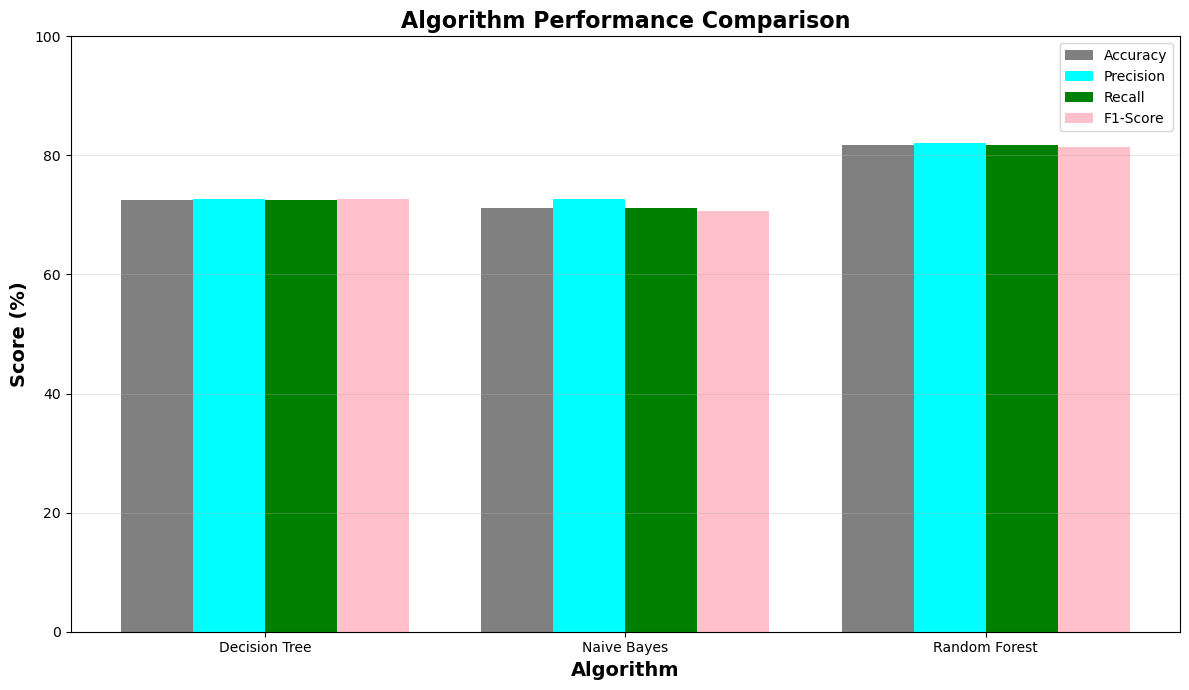

In [124]:
# Creating plot
fig, ax = plt.subplots(figsize=(12, 7))
width = 0.2
x = [0, 1, 2]

# Ploting bars
ax.bar([i - 1.5*width for i in x], accuracy, width, label='Accuracy', color='grey')
ax.bar([i - 0.5*width for i in x], precision, width, label='Precision', color='cyan')
ax.bar([i + 0.5*width for i in x], recall, width, label='Recall', color='green')
ax.bar([i + 1.5*width for i in x], f1, width, label='F1-Score', color='pink')

# Labels
ax.set_xlabel('Algorithm', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=14, fontweight='bold')
ax.set_title('Algorithm Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()